In [ ]:
!pip install pytorch-forecasting

In [ ]:
import numpy as np
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# This dataset is already included in pytorch forecasting library so import it using below commands:
from pytorch_forecasting.data.examples import get_stallion_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
lsp_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/new_data_train.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lsp_train

,Unnamed: 0,date,store_nbr,product_type,sales,onpromotion,oil_price,catastrophe,transactions,week,day,weekday,month,pay_day,city,store_type,store_cluster,holiday
0,0,2013-01-01,1,1,0.000,0,0,0,1693,1,1,2,1,0,Quito,D,13.0,1
1,1,2013-01-01,1,2,0.000,0,0,0,1693,1,1,2,1,0,Quito,D,13.0,1
2,2,2013-01-01,1,3,0.000,0,0,0,1693,1,1,2,1,0,Quito,D,13.0,1
3,3,2013-01-01,1,4,0.000,0,0,0,1693,1,1,2,1,0,Quito,D,13.0,1
4,4,2013-01-01,1,5,0.000,0,0,0,1693,1,1,2,1,0,Quito,D,13.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,29,438.133,0,0,0,2155,33,227,2,8,1,Quito,B,6.0,0
3000884,3000884,2017-08-15,9,30,154.553,1,0,0,2155,33,227,2,8,1,Quito,B,6.0,0
3000885,3000885,2017-08-15,9,31,2419.729,148,0,0,2155,33,227,2,8,1,Quito,B,6.0,0
3000886,3000886,2017-08-15,9,32,121.000,8,0,0,2155,33,227,2,8,1,Quito,B,6.0,0


In [ ]:
startDate =  pd.to_datetime(lsp_train.loc[0,'date'])
lsp_train["time_idx"] = (pd.to_datetime(lsp_train['date'], errors='coerce') - startDate).dt.days


In [ ]:
#static
lsp_train["product_type"] = lsp_train["product_type"].astype("string").astype("category")
lsp_train["store_nbr"] = lsp_train["store_nbr"].astype("string").astype("category")
lsp_train["store_type"] = lsp_train["store_type"].astype("string").astype("category")
lsp_train["city"] = lsp_train["city"].astype("string").astype("category")
lsp_train["store_cluster"] = lsp_train["store_cluster"].astype("string").astype("category")


lsp_train["month"] = lsp_train["month"].astype("string").astype("category")
lsp_train["day"] = lsp_train["day"].astype("string").astype("category")
lsp_train["week"] = lsp_train["week"].astype("string").astype("category")
lsp_train["weekday"] = lsp_train["weekday"].astype("string").astype("category")
lsp_train["holiday"] = lsp_train["holiday"].astype("string").astype("category")
lsp_train["pay_day"] = lsp_train["pay_day"].astype("string").astype("category")

In [ ]:
max_prediction_length = 14
max_encoder_length = 60
training_cutoff = lsp_train["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    lsp_train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["product_type", "store_nbr"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["product_type", "store_nbr", "city", 'store_type', 'store_cluster'],
    static_reals=[],
    time_varying_known_categoricals=["month", "day","week","weekday","pay_day","holiday"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "transactions", "onpromotion", "oil_price", "catastrophe"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "sales",
        # "log_volume",
        # "industry_volume",
        # "soda_volume",
        # "avg_max_temp",
        # "avg_volume_by_agency",
        # "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["product_type", "store_nbr"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, lsp_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # setting it between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=75,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=5,  # coment in for training, running valiation every 30 batches
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=88,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=13,  # 133 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 18.5 K
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 8.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 17.7 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 31.5 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 31.5 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=75` reached.


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


tensor(88.3971)

Prediction(output=Output(prediction=tensor([[[3.0364e-05, 5.5943e-02, 7.5813e-01,  ..., 8.2472e+00,
          9.4075e-05, 8.6247e+00],
         [5.8111e-05, 2.5733e-02, 5.7153e-01,  ..., 8.4997e+00,
          1.0007e-04, 6.8650e+00],
         [1.5878e-05, 3.2816e-02, 6.0634e-01,  ..., 7.5958e+00,
          9.0852e-05, 9.3028e+00],
         ...,
         [2.3898e-07, 7.6604e-03, 1.4252e+00,  ..., 5.2013e+00,
          2.2295e-05, 8.7901e+00],
         [1.0314e-06, 2.2981e-03, 3.2965e-01,  ..., 6.1263e+00,
          4.6210e-05, 8.3045e+00],
         [1.1658e-06, 1.1275e-03, 8.8497e-02,  ..., 6.9826e+00,
          3.0828e-05, 9.6907e+00]],

        [[9.7905e-08, 3.2291e-05, 6.8821e-04,  ..., 6.5481e+00,
          1.3197e-04, 9.9891e+00],
         [1.2394e-07, 8.7923e-06, 2.7329e-04,  ..., 6.5615e+00,
          1.7035e-04, 8.4411e+00],
         [3.1502e-08, 1.0217e-05, 2.4590e-04,  ..., 5.5063e+00,
          1.4472e-04, 1.0473e+01],
         ...,
         [1.0933e-09, 9.0128e-06, 1.2407e-0

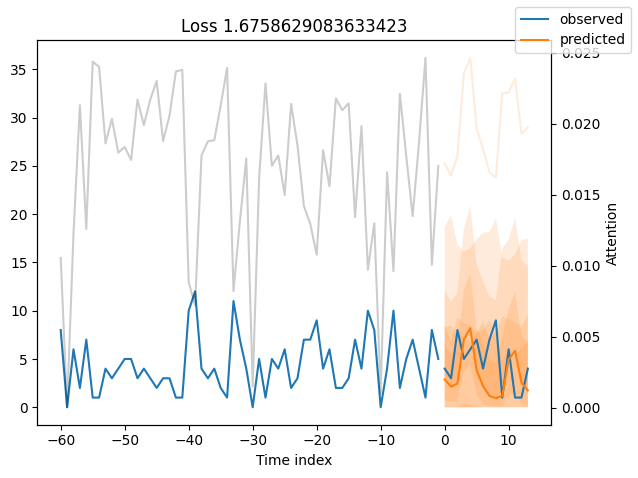

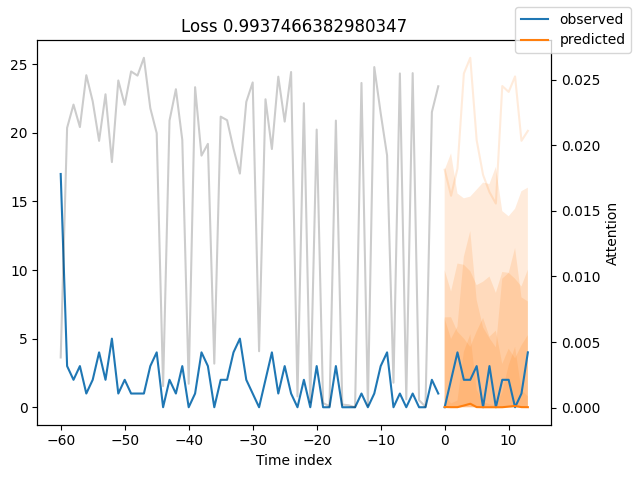

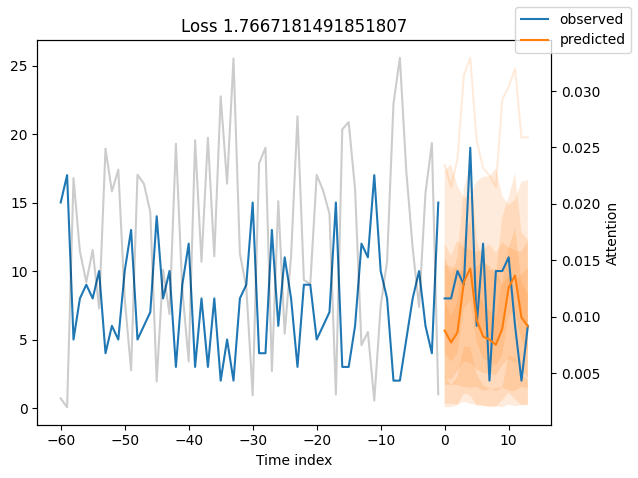

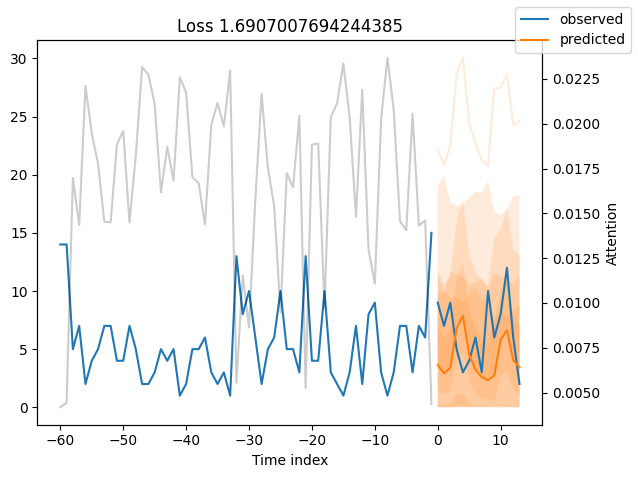

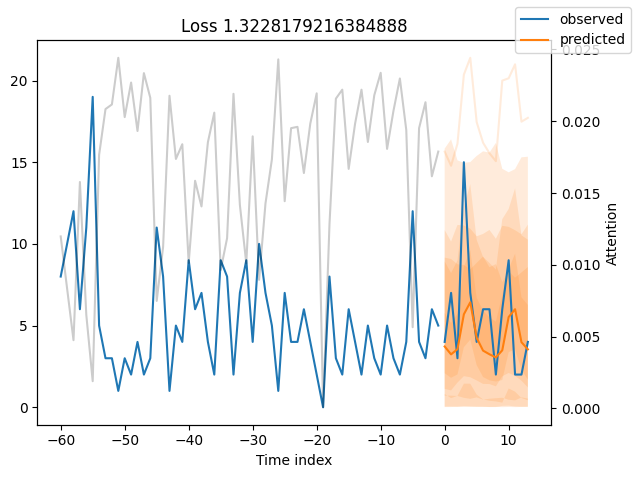

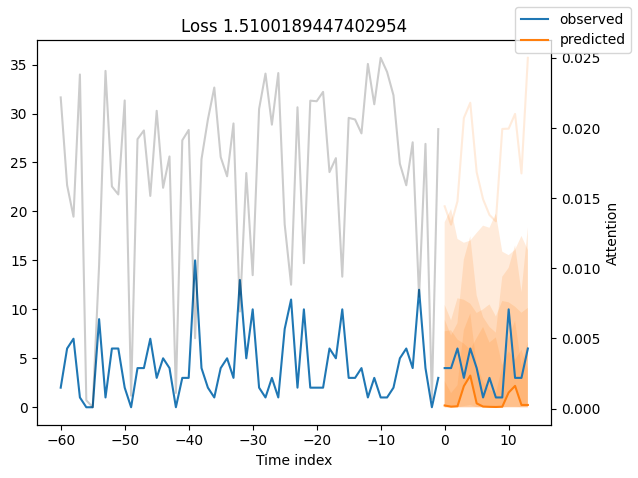

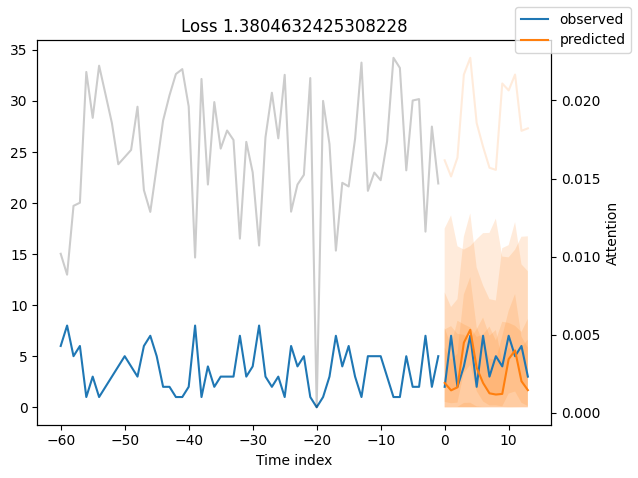

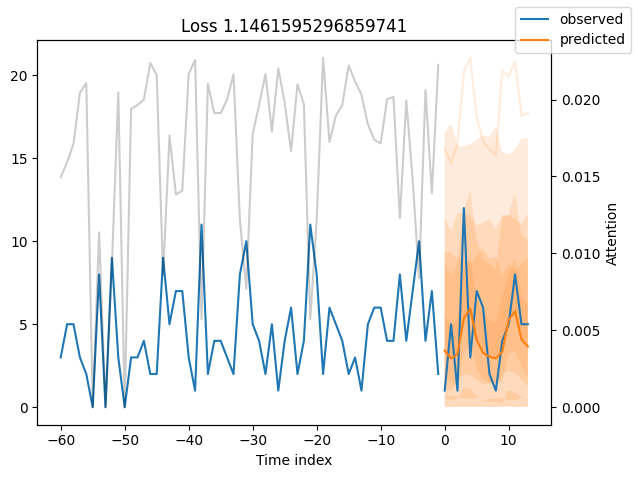

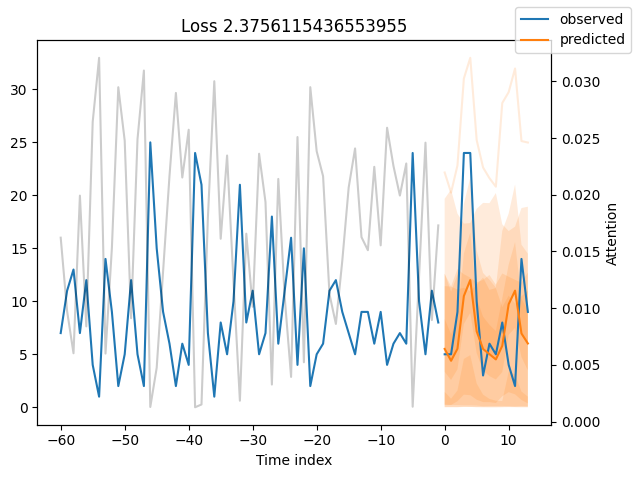

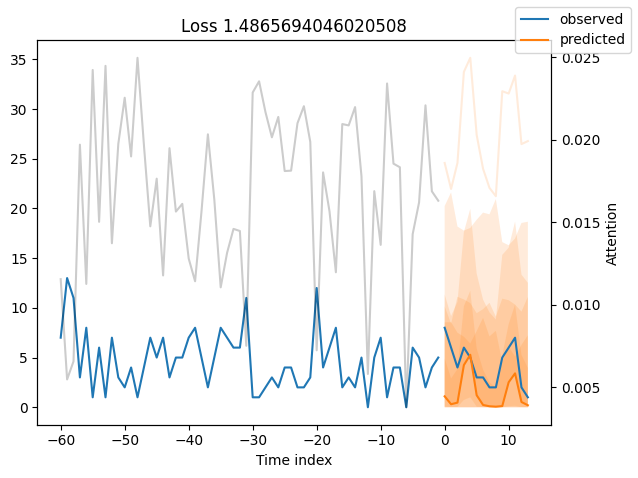

In [ ]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True);

print(raw_predictions)